# Курсовая работа на тему "Исследование датасетов"

## Выполнена студентом группы М8О-114М-22 Дмитроченко Б.А.

### 0. Выбор датасета

Для курсового проекта был выбран датасет Stanford Cars (https://paperswithcode.com/dataset/stanford-cars)

### 1. Импорт датасета

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import jovian
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

C:\Users\bonjo\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder'
od.download(dataset_url)

Skipping, found downloaded files in ".\stanford-car-dataset-by-classes-folder" (use force=True to force download)


In [4]:
from torch.utils.data import Dataset

In [5]:
import os

DATA_DIR_TRAIN = './stanford-car-dataset-by-classes-folder/car_data/car_data/train'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST = './stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_classes = os.listdir(DATA_DIR_TEST)

train_classes[5:10], test_classes[5:10]

(['Acura ZDX Hatchback 2012',
  'AM General Hummer SUV 2000',
  'Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin V8 Vantage Coupe 2012',
  'Aston Martin Virage Convertible 2012'],
 ['Acura ZDX Hatchback 2012',
  'AM General Hummer SUV 2000',
  'Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin V8 Vantage Coupe 2012',
  'Aston Martin Virage Convertible 2012'])

In [6]:
def find_classes(dir):
    train_classes = os.listdir(dir)
    train_classes.sort()
    train_class_to_idx = {train_classes[i]: i for i in range(len(train_classes))}
    return train_classes, train_class_to_idx
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx

train_classes, train_c_to_idx = find_classes(DATA_DIR_TRAIN)
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [7]:
len(train_classes), len(test_classes)

(196, 196)

In [8]:
def find_classes(dir):
    test_classes = os.listdir(dir)
    test_classes.sort()
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [9]:
def extract_class(Datasets, slice):
    count = 0
    for vals in os.listdir(Datasets):
        print(vals)
        count+=1
        if count>slice:
            break;

In [10]:
extract_class(DATA_DIR_TRAIN, 10)

Acura Integra Type R 2001
Acura RL Sedan 2012
Acura TL Sedan 2012
Acura TL Type-S 2008
Acura TSX Sedan 2012
Acura ZDX Hatchback 2012
AM General Hummer SUV 2000
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Coupe 2012
Aston Martin Virage Convertible 2012
Aston Martin Virage Coupe 2012


In [11]:
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = ToTensor())
test_dataset = ImageFolder(DATA_DIR_TEST, transform = ToTensor())

In [12]:
for _ in range (5):
    image, label = train_dataset[np.random.randint(len(train_dataset))]
    print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 221, 441]) Label: 29
image_shape: torch.Size([3, 480, 640]) Label: 190
image_shape: torch.Size([3, 225, 300]) Label: 94
image_shape: torch.Size([3, 194, 259]) Label: 77
image_shape: torch.Size([3, 540, 900]) Label: 133


In [13]:
for _ in range (5):
    image, label = test_dataset[np.random.randint(len(test_dataset))]
    print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 480, 640]) Label: 123
image_shape: torch.Size([3, 743, 1024]) Label: 0
image_shape: torch.Size([3, 768, 1024]) Label: 188
image_shape: torch.Size([3, 124, 166]) Label: 66
image_shape: torch.Size([3, 435, 653]) Label: 46


### 2. Описание датасета

Датасет состоит из 196 классов автомобилей с общим количеством изображений в 16185 штук, снятых сзади. Количество тренировочных и тестовых данных примерно равно (8144 тренировочных и 8041 тестовых). Присутствуют категории "Make" (марка производителя), "Model" (модель), "Year" (год выпуска - прим. автора). Размер изображений - 360х240.
Впервые датасет был представлен в 2017-м году в статье, посвященной разработке сверточной нейронной сети для распознавания изображений (статья - https://arxiv.org/pdf/1702.01721.pdf).
Сегодня этот датасет используется для проектирования спроецированных генеративно-состязательных сетей с быстрой сходимостью (https://arxiv.org/pdf/2111.01007v1.pdf). Суть таких сетей заключается в проецировании реальных и сгенерированных изображений в фиксированное, предварительно подготовленное пространство объектов, таким образом улучшается качество изображений, повышается эффективность выборки и скорость конвергенции.

Генеративно-состязательные сети нацелены на моделирование распределения данного обучающего набора данных. Генератор $G$ сопоставляет скрытые векторы $z$, отобранные из простого распределения $P_z$ (обычно нормального распределения), с соответствующими сгенерированными выборками $G(z)$. Затем дискриминатор $D$ нацелен на то, чтобы отличать реальные выборки $x ∼ P_x$ от сгенерированных выборок $G(z) ∼ P_G(z)$. Эта основная идея приводит к следующей формуле: $$\min_{G}\max_{D}(E_x[\log D(x)] + E_z[\log(1 - D(G(z)))])$$
Мы вводим набор проекторов объектов $\left\{P_l\right\}$, которые отображают реальные и сгенерированные изображения во входное пространство дискриминатора. Таким образом, прогнозируемое обучение генеративно-состязательной сети может быть сформулировано следующим образом

$$\min_{G}\max_{\left\{D_l\right\}}\sum_{l\epsilon\mathcal{L}}(E_x[\log D_l(P_l(x))] + E_z[\log(1 - D_l(P_l(G(z))))])$$

### 3. Пример данных с разметкой и загрузка тестового набора 

In [14]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Dodge Durango SUV 2012 (91)


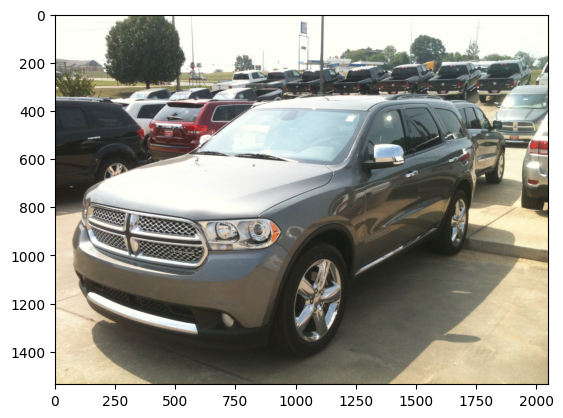

In [15]:
show_example(*train_dataset[np.random.randint(len(train_dataset))])

Label:  Nissan 240SX Coupe 1998 (167)


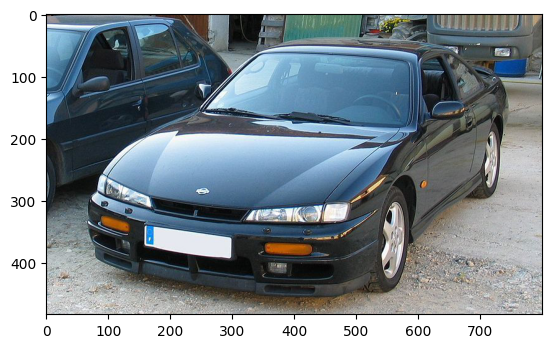

In [16]:
show_example(*test_dataset[np.random.randint(len(test_dataset))])

In [17]:
train_tfms = tt.Compose([tt.Resize((256, 256)),
                         tt.RandomRotation(0),
                         tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [18]:
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = train_tfms)
test_dataset = ImageFolder(DATA_DIR_TEST, transform = test_tfms)

In [19]:
test_dataset.classes[42:47]

['Bentley Continental Supersports Conv. Convertible 2012',
 'Bentley Mulsanne Sedan 2011',
 'Bugatti Veyron 16.4 Convertible 2009',
 'Bugatti Veyron 16.4 Coupe 2009',
 'Buick Enclave SUV 2012']

In [20]:
len(train_dataset), len(test_dataset)

(8144, 8041)

In [21]:
random_seed = 42
torch.manual_seed(random_seed);

In [22]:
val_percent = 0.1
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(7330, 814)

In [23]:
!pip install jovian --upgrade --quiet

In [24]:
jovian.log_dataset(dataset_url = dataset_url, val_size = val_size, random_seed = random_seed)

[jovian] Dataset logged.


In [25]:
batch_size = 128

In [26]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers = 4, pin_memory=True)

In [27]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12,6))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


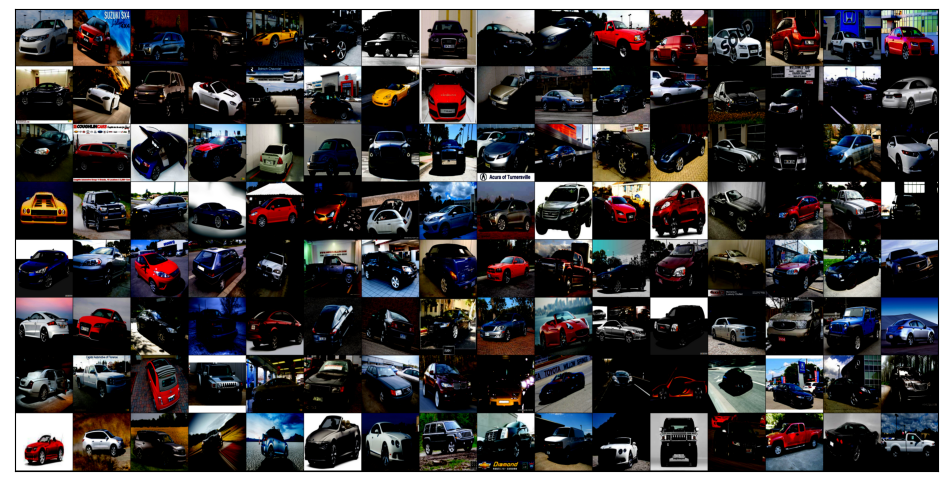

In [28]:
show_batch(train_dl);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


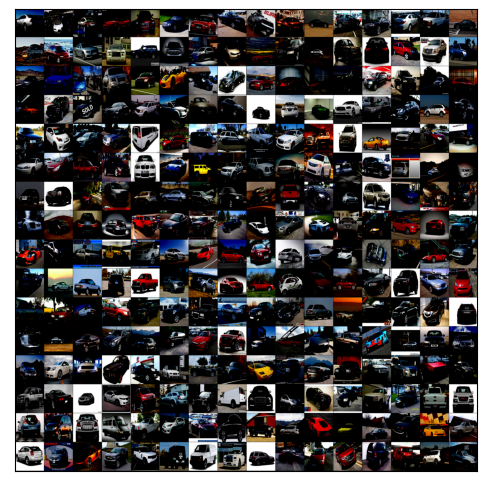

In [29]:
show_batch(val_dl); 

### 4. Пример применения готовой модели на данных

Произведем обучение на сверточной нейронной сети

In [30]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(2,2)
)

In [31]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = simple_model(images)
  print('out.shape:', out.shape)
  break

images.shape: torch.Size([128, 3, 256, 256])
out.shape: torch.Size([128, 8, 128, 128])


In [32]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
class StanfordCarsModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(64*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 196))
        
    def forward(self, xb):
        return self.network(xb)

In [34]:
model = StanfordCarsModel()
#model

In [35]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]:', out[0])
  break

images.shape: torch.Size([128, 3, 256, 256])
out.shape: torch.Size([128, 196])
out[0]: tensor([ 2.1798e-02, -1.5204e-02,  4.6250e-03, -3.0544e-02, -3.8073e-03,
        -2.8039e-02,  4.8566e-02,  1.4946e-02,  8.3471e-03,  3.7493e-02,
        -1.3038e-02, -3.6717e-02, -1.3989e-02,  1.4498e-02,  1.9505e-02,
        -1.3528e-02, -2.5837e-02,  2.6661e-02, -4.1389e-02, -2.7094e-02,
        -4.3256e-02,  3.0318e-02,  4.5738e-02, -2.5869e-02,  1.0035e-02,
         3.1076e-02,  3.5090e-02, -3.5105e-02, -3.0826e-02, -2.2223e-02,
         2.9261e-02,  2.0134e-03,  1.2163e-02, -4.5489e-02,  2.4741e-02,
        -6.5773e-05,  1.1286e-02,  2.4070e-02,  1.2962e-02, -1.4373e-02,
        -3.6612e-02, -2.0977e-02,  3.0480e-02, -5.0220e-02, -3.7621e-02,
         3.0301e-02,  4.6111e-03,  1.9273e-02, -1.8635e-02,  2.1344e-02,
         5.2925e-03, -3.1078e-02,  4.0403e-02, -3.3261e-02,  3.8229e-02,
        -3.3765e-02, -2.4655e-02,  3.1449e-02,  6.6232e-04,  3.4222e-02,
         1.0025e-02,  8.2900e-03,  2.

In [36]:
def get_default_device():
    return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cpu')

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [45]:
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
%reload_ext tensorboard
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            writer = SummaryWriter()
            writer.add_scalar('Loss', loss, epoch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [46]:
model = to_device(StanfordCarsModel(), device)

In [47]:
evaluate(model, val_dl)

{'val_loss': 5.2801313400268555, 'val_acc': 0.0029296875}

In [48]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5e-2

In [49]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [50]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 179070.6406, val_loss: 5.3159, val_acc: 0.0049
Epoch [1], train_loss: 5.2997, val_loss: 5.2999, val_acc: 0.0226
Epoch [2], train_loss: 5.2950, val_loss: 5.3001, val_acc: 0.0226
Epoch [3], train_loss: 5.2920, val_loss: 5.2961, val_acc: 0.0226
Epoch [4], train_loss: 5.2923, val_loss: 5.2935, val_acc: 0.0226
Epoch [5], train_loss: 5.2905, val_loss: 5.2956, val_acc: 0.0226
Epoch [6], train_loss: 5.2898, val_loss: 5.2952, val_acc: 0.0226
Epoch [7], train_loss: 5.2897, val_loss: 5.2956, val_acc: 0.0226
Epoch [8], train_loss: 5.2910, val_loss: 5.2885, val_acc: 0.0226
Epoch [9], train_loss: 5.2910, val_loss: 5.2929, val_acc: 0.0226


In [51]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [52]:
test_dataset = ImageFolder(DATA_DIR_TEST, transform = test_tfms)

In [53]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Chevrolet Silverado 1500 Regular Cab 2012 , Predicted: GMC Savana Van 2012


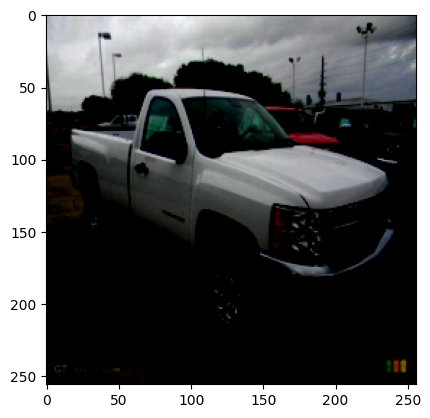

In [55]:
img, label = test_dataset[np.random.randint(len(test_dataset))]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [56]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 5.274835586547852, 'val_acc': 0.00830078125}

### 5. Вывод статистических данных

С помощью Plotly было отображено распределение количества изображений машин для каждого класса.

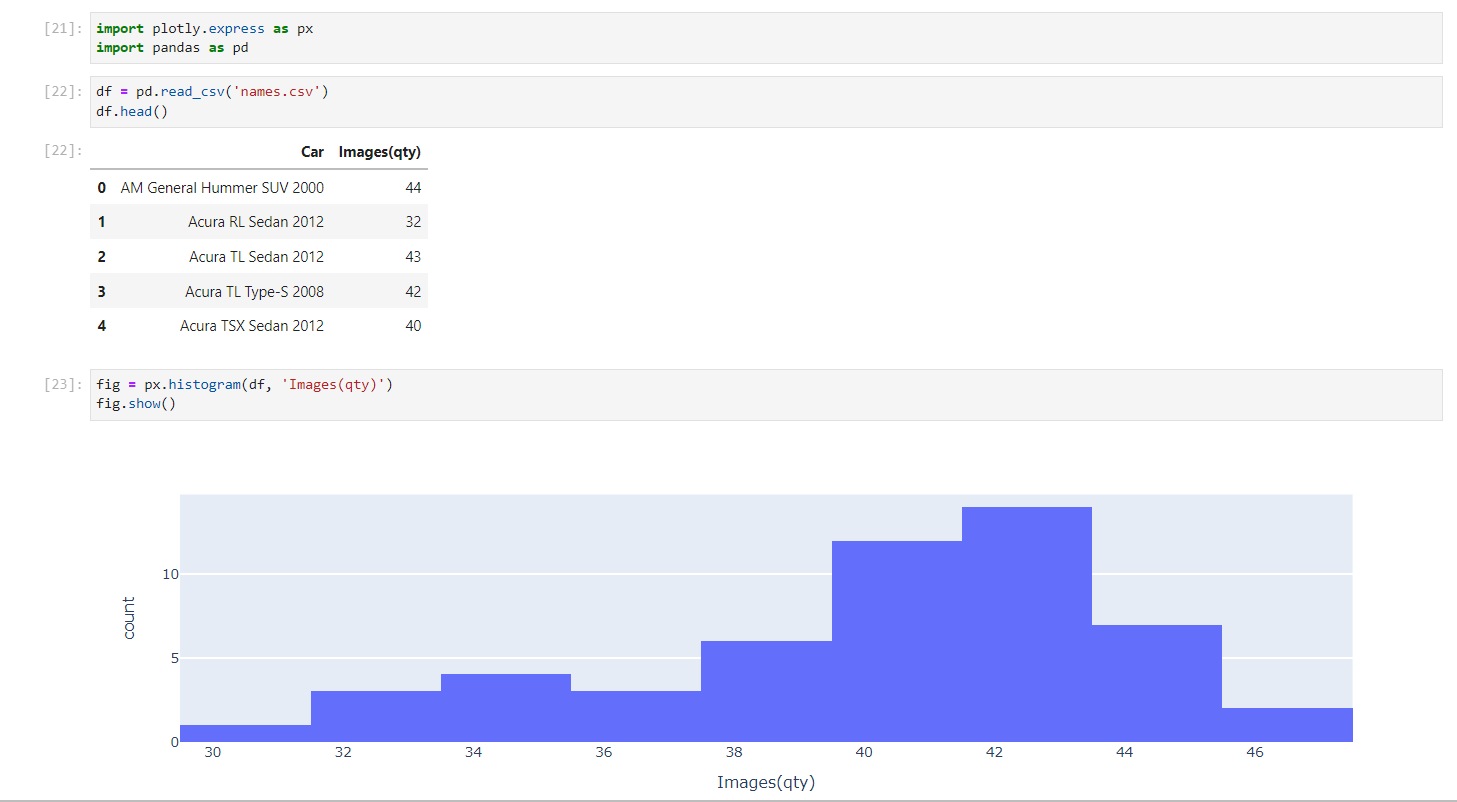

### 6. TensorBoard

Вывод графиков осуществляется с помощью команды: __tensorboard --logdir=runs__
На графике рассматривалась динамика функции потерь

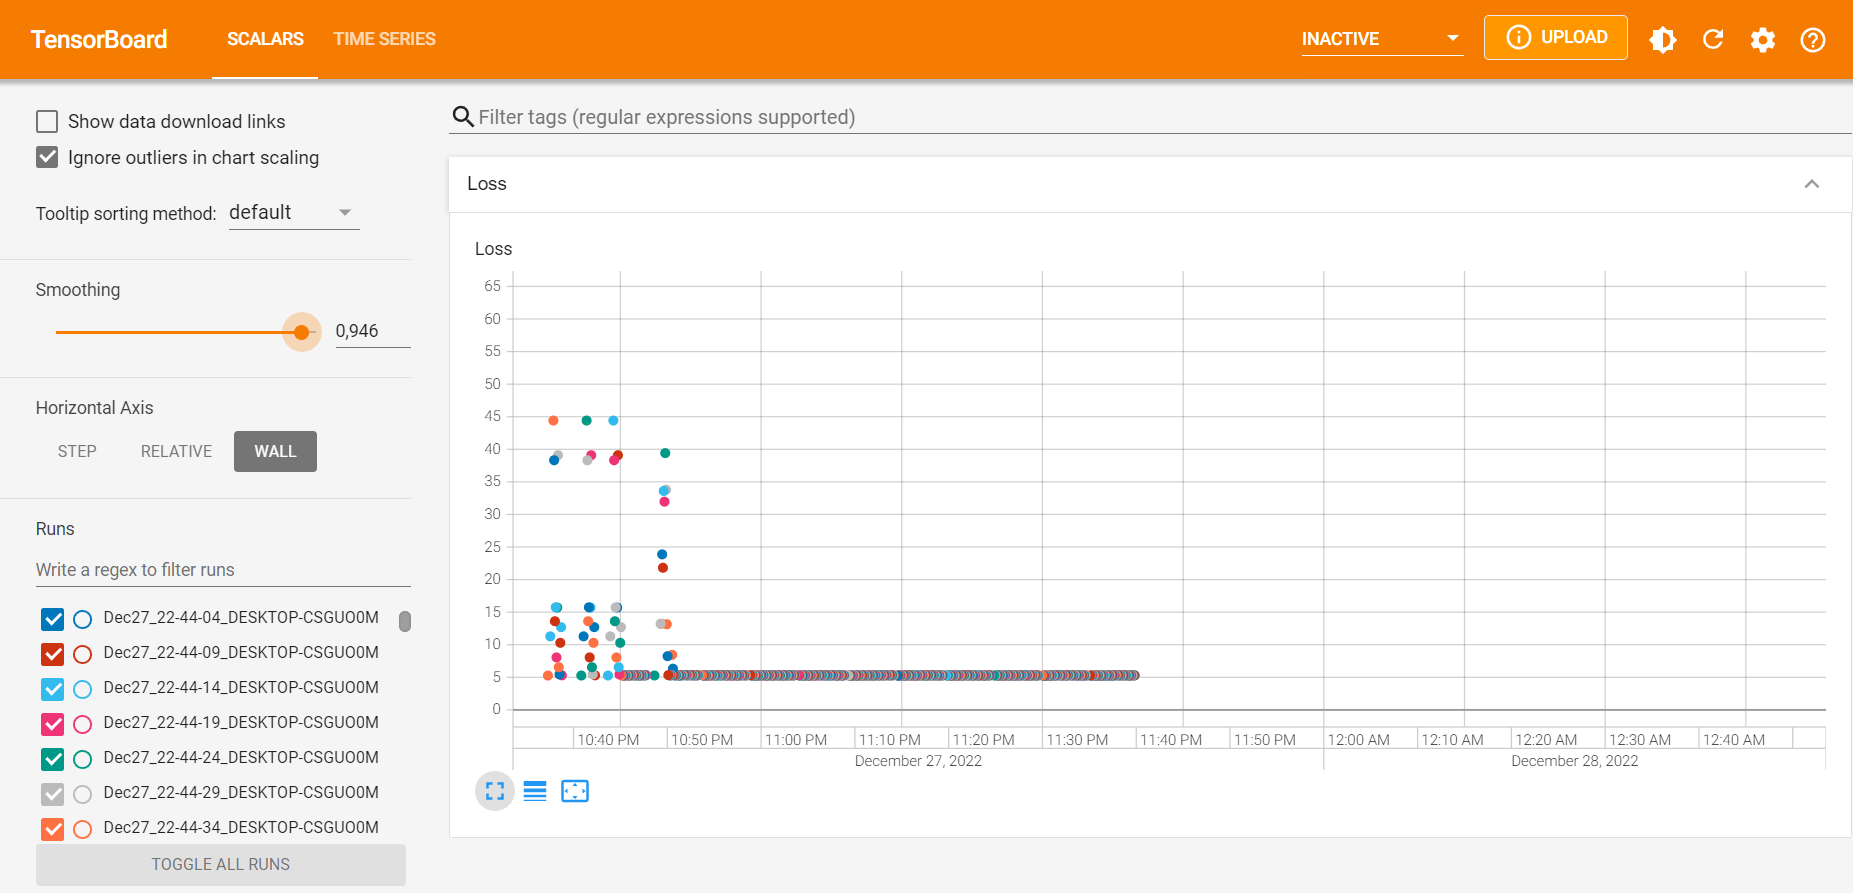